In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
#import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont 
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import csv

import tensorflow as tf

from keras.utils import load_img, img_to_array

#from object_detection.utils import label_map_util
#from object_detection.utils import config_util
#from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
#from object_detection.utils import config_util
#from object_detection.builders import model_builder

%matplotlib inline

2023-12-23 14:19:25.344321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 14:19:25.344378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 14:19:25.410173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 14:19:25.550116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# DO NOT RUN

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

In [ ]:
# DO NOT RUN
!python models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint'} \
    --output_directory {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/tflite'} \
    --pipeline_config_path {'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config'}

In [ ]:
# DO NOT RUN
_TFLITE_MODEL_PATH = "onnx/ssd/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('onnx/ssd/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(_TFLITE_MODEL_PATH, 'wb') as f:
  f.write(tflite_model)

In [4]:
def preprocess(image):
    image = load_img(image, target_size=(300, 300))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = image.astype(np.uint8)
    #image = preprocess_input(image)
    return image

def postprocess_detections(out, conf_thresh=0.5):
    for i in out:
        print(i, out[i].shape)
    dscores = out["detection_scores"]
    assert (dscores.shape[0] == 1)
    dscores = dscores.flatten()
    top_indices = [i for i, conf in enumerate(dscores.flatten()) if conf >= conf_thresh]
    top_scores = dscores[top_indices]

    dboxes = out["detection_boxes"]
    top_dboxes = [dboxes[0,i,:] for i in top_indices]
    
    dclasses = out["detection_classes"]
    top_classes = [dclasses[0,i] for i in top_indices]
    top_classes = [round(x) for x in top_classes]

    return (top_dboxes, top_classes, top_scores)
    
# returns key1 in {key1: value1, key2: value2 ...}
def get_first_key(dictionary):
    for key in dictionary:
        return key
    return None
    
# returns a tuple (runner, inputname, outputname)
def get_runner_and_io_names(interpreter):
    # signature list is of the form {key: {inputs: value, outputs: values}}
    signature_dict = interpreter.get_signature_list()
    first_key = get_first_key(signature_dict)
    runner = interpreter.get_signature_runner(first_key)
    io_dict = signature_dict[first_key]
    inputname = io_dict['inputs'][0]
    outputnames = io_dict['outputs']
    return (runner, inputname, outputnames)

def read_label_file(filename):
    with open(filename, 'r') as file:
        csv_reader = csv.reader(file)
        data_list = np.full(91, "Unknown")
        data_list[0] = "background"
        for row in csv_reader:
            data_list[int(row[0])] = row[2]
    return data_list

def forward(image, interpreter):
    image = preprocess(image)
    runner, inputname, outputname = get_runner_and_io_names(interpreter)
    out = runner(input_tensor=image)
    out = runner(input_tensor=image)
    return postprocess_detections(out, conf_thresh=0.40)

def plot_detections(image, top_boxes, top_classes, top_scores):
    img = Image.open(image)

    img = img.resize((300, 300))
    img_draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("NotoSans-Regular.ttf", 12)
    font_smaller = ImageFont.truetype("NotoSans-Regular.ttf", 8)

    label_map = read_label_file("ms_coco_labels.txt")
    for i,j,k in zip(top_boxes,top_classes,top_scores):
        boxes = (i * 300)
        assert(len(boxes) == 4)
        # Coordinates in boxes are stored in [ymin, xmin, ymax, xmax] order
        # and img_draw.rectangle later expects [xmin, ymin, xmax, ymax]
        ymin, xmin, ymax, xmax = boxes
        img_draw.rectangle([xmin, ymin, xmax, ymax], outline=(255, 0, 0))
        img_draw.text([xmin + 10, ymin], label_map[j], font=font)
        img_draw.text([xmax - 45, ymax - 15], str(k), font=font_smaller)  
    img.save('detect_result.jpg')
    return image

def show_img(image):
    img = Image.open(image)
    display(img)

In [5]:
interpreter = tf.lite.Interpreter(model_path="/home/metal/dev/vaaman-cnn/onnx/ssd/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/model.tflite")
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


detection_anchor_indices (1, 100)
detection_boxes (1, 100, 4)
detection_classes (1, 100)
detection_multiclass_scores (1, 100, 91)
detection_scores (1, 100)
num_detections (1,)
raw_detection_boxes (1, 51150, 4)
raw_detection_scores (1, 51150, 91)


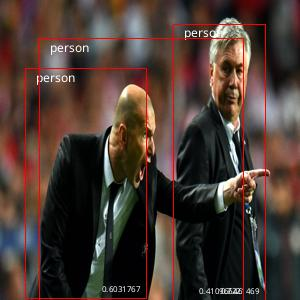

detection_anchor_indices (1, 100)
detection_boxes (1, 100, 4)
detection_classes (1, 100)
detection_multiclass_scores (1, 100, 91)
detection_scores (1, 100)
num_detections (1,)
raw_detection_boxes (1, 51150, 4)
raw_detection_scores (1, 51150, 91)


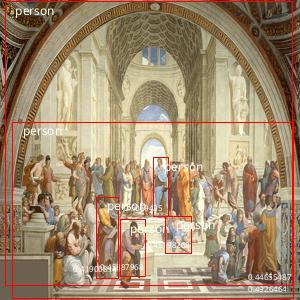

detection_anchor_indices (1, 100)
detection_boxes (1, 100, 4)
detection_classes (1, 100)
detection_multiclass_scores (1, 100, 91)
detection_scores (1, 100)
num_detections (1,)
raw_detection_boxes (1, 51150, 4)
raw_detection_scores (1, 51150, 91)


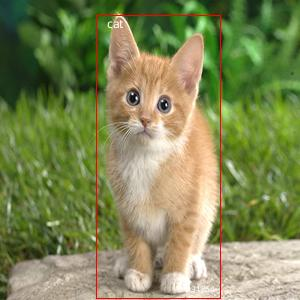

detection_anchor_indices (1, 100)
detection_boxes (1, 100, 4)
detection_classes (1, 100)
detection_multiclass_scores (1, 100, 91)
detection_scores (1, 100)
num_detections (1,)
raw_detection_boxes (1, 51150, 4)
raw_detection_scores (1, 51150, 91)


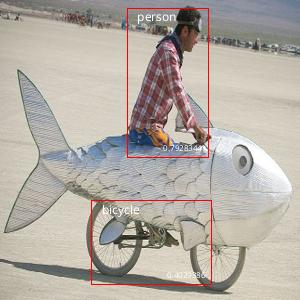

In [6]:
img_path = ["images/zidane.jpg", "images/soa.jpg", "images/cat.jpg", "images/fish-bike.jpg"]
for i in img_path:
    top_dboxes, top_classes, top_scores = forward(i, interpreter)
    plot_detections(i, top_dboxes, top_classes, top_scores)
    show_img("detect_result.jpg")

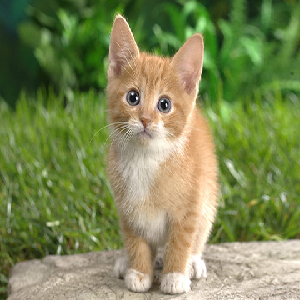

NameError: name 'runner' is not defined

In [8]:
img_path = "images/cat.jpg"
img = preprocess(img_path)
pil_img = Image.fromarray(img.reshape(300, 300, 3), "RGB")
display(pil_img)
out = runner(input_tensor=img)

In [7]:
top_dboxes, top_classes, top_scores = postprocess_detections(out)
plot_detections(img_path, top_dboxes, top_classes, top_scores)
show_img("detect_result.jpg")

NameError: name 'out' is not defined

In [5]:
tensor_details = interpreter.get_input_details()

In [28]:
%%capture myout
#num_layer = 300
#for i in range(num_layer):
#    detail = interpreter._get_tensor_details(i,0)
#    print(i, detail['name'], detail['shape'])

for i in tensor_details:
    print(i['name'], i['shape'])

In [29]:
with open("myfile.txt", "w") as outfile:
    outfile.write(myout.stdout)

In [9]:
# Proof of 5 mbox source feature layers for ssd_mobilenet_v2_fpnlite_640x640_coco17
_fpn_max_level = 7
_fpn_min_level = 3
feature_blocks = [ 'layer_4', 'layer_7', 'layer_14', 'layer_19' ]
base_fpn_max_level = min(_fpn_max_level, 5)
feature_maps = []
for level in range(_fpn_min_level, base_fpn_max_level + 1):
    feature_maps.append(feature_blocks[level - 2])
for i in range(base_fpn_max_level + 1, _fpn_max_level + 1):
    feature_maps.append('a_layer')
print(feature_maps)

['layer_7', 'layer_14', 'layer_19', 'a_layer', 'a_layer']


In [10]:
def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []
    # Bounding boxes
    boxes = np.array(bounding_boxes)
    # coordinates of bounding boxes
    # [ymin, xmin, ymax, xmax]
    start_y = boxes[:, 0]
    start_x = boxes[:, 1]
    end_y = boxes[:, 2]
    end_x = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)
        left = np.where(ratio < threshold)
        order = order[left]
    return picked_boxes, picked_score

In [46]:
## NON MAXIMUM SUPPRESION

In [71]:
image = preprocess("images/zidane.jpg")
runner, inputname, outputname = get_runner_and_io_names(interpreter)
out = runner(input_tensor=image)
raw_box = np.squeeze(out["raw_detection_boxes"])
raw_scores = np.squeeze(out["raw_detection_scores"])
print(raw_box.shape)
print(raw_scores.shape)

(51150, 4)
(51150, 91)


In [102]:
def get_conf_arr(raw_scores, i):
    """ get ith conf_arr from raw_scores (51150,91) """
    return np.squeeze(raw_scores[:,i:i+1])

def normalize_raw_boxes(raw_box):
    """ 
        raw_box: (out["raw_detection_boxes"]) (51150, 4)
        return: normalized raw_box (51150, 4)
    """
    assert(raw_box.shape[1] == 4)
    split = np.squeeze(np.array(np.split(raw_box, 4, axis=1)))
    new_raw_box = []
    for i, split_arr in enumerate(split):
        new_raw_box.append((np.array(tf.math.sigmoid(split_arr)) * 300))
    return np.swapaxes(np.array(new_raw_box), 0, 1)

def run_raw_detections(interpreter, imagepath):
    image = preprocess(imagepath)
    runner, inputname, outputname = get_runner_and_io_names(interpreter)
    out = runner(input_tensor=image)
    raw_box = np.squeeze(out["raw_detection_boxes"])
    raw_scores = np.squeeze(out["raw_detection_scores"])
    norm_boxes = normalize_raw_boxes(raw_box)
    iou_threshold = 0.6
    for i in range(91):
        conf_arr = get_conf_arr(raw_box, i)
        picked_boxes, picked_scores = nms(norm_boxes, conf_arr, iou_threshold)
        return picked_boxes, picked_scores
        print(f"Picked boxes for class {i}: {len(picked_boxes)}")
        print(f"Picked scores for class {i}: {len(picked_scores)}")

In [103]:
picked_boxes, picked_scores = run_raw_detections(interpreter, "images/cat.jpg")

In [13]:
conf_arr = get_conf_arr(raw_scores, 28)
picked_boxes, picked_scores = nms(raw_box, conf_arr, 0.5)

In [14]:
split = np.squeeze(np.array(np.split(raw_box, 4, axis=1)))

In [81]:
r = split[0] * 0.1
r = r * np.load("tensor0mul")
r = r * np.load("tensor0add")

m3 = split[1] * 0.2
m2 = np.exp(m3)
m1 = m2 * np.load("tensor1mul")
m0 = m1 * 0.5

k0 = split[2] * 0.1
k1 = k0 * np.load("tensor2mul")
k2 = k1 + np.load("tensor2add")

t0 = split[3] * 0.2
t1 = np.exp(t0)
t2 = t1 * np.load("tensor3mul")
t3 = t2 * 0.5

r0 = m0 + r
r1 = r0 - r
r2 = k2 - t3
r3 = t3 + k2

# min mma
# max memm

In [96]:
norm_box = np.swapaxes(np.stack((r0,r1,r2,r3)), 0, 1)

100
100


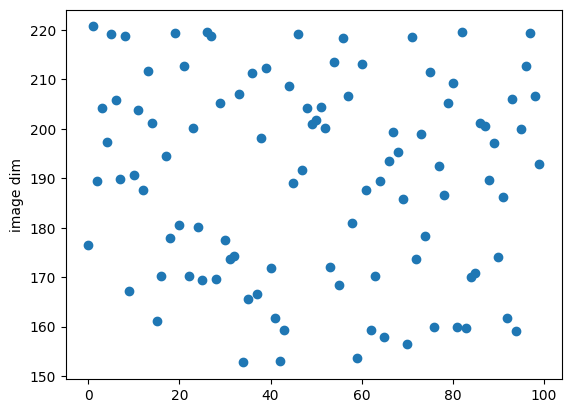

In [43]:
import matplotlib.pyplot as plt
import random

split3 = (np.array(tf.math.sigmoid(split[3])) * 300)
#split3 = np.array(split[3] * 300)
x = np.array(range(100))
sp = random.choices(split3, k=100)
print(len(x))
print(len(sp))

plt.scatter(x, sp)
plt.ylabel('image dim')
plt.show()

In [102]:
np.max(norm_box.flatten())

2.173276

In [104]:
np.min(out["detection_boxes"].flatten())

0.0

In [1]:
# full raw -> sigmoid on boxes -> nms -> plot
# full raw -> norm -> sigmoid on boxes -> nms -> plot

In [2]:
# Run 90 NMS
for i in range(90):
    

NameError: name 'out' is not defined